In [1]:
from joblib import dump, load
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

In [2]:
import xgboost as xgb

In [3]:
import sys
sys.path.append('temp/temp/')
import make_tissue as mt

In [4]:
def mean_OD(spectra,wvs,wvl,window):
    left_wvl = wvl-(window/2.)
    right_wvl = wvl+(window/2.)
    wvl_mask = (left_wvl<=wvs) & (wvs<=right_wvl)
    return spectra[wvl_mask].mean()
def mean_R(spectra,wvl,window):
    left_wvl = wvl-(window/2.)
    right_wvl = wvl+(window/2.)
    wvl_mask = (left_wvl<=all_wvs) & (all_wvs<=right_wvl)
    return spectra[wvl_mask].mean()
def line(spectra,wvl_1,wvl_2):
    y_1 = mean_OD(spectra,wvl_1,2.)
    y_2 = mean_OD(spectra,wvl_2,2.) 
    a = (y_2 - y_1)/(wvl_2-wvl_1)
    b = (y_1*wvl_2-y_2*wvl_1)/(wvl_2-wvl_1)
    return a*wvs+b
def line_correction(spectra,left_wvl,right_wvl):
    return spectra - line(spectra,left_wvl,right_wvl)
def norm(y):
    return (y-y.min())/(y.max()-y.min())

## Train test split

In [5]:
csv_file='2_layered_model_mcml.csv'

data = pd.read_csv(csv_file)

distances = np.arange(0.0025,1.5,0.005).round(4)

data.columns = np.append(distances,['mua1', 'mus1', 'd1','mua2', 'mus2','d2'])
data.drop((np.arange( 0.3225,1.5,0.005).round(4).astype(str)), axis=1, inplace=True)
data.drop('d2', axis=1, inplace=True)
optical = ['mua1','mus1','d1','mua2','mus2']
Rs = [r for r in data.columns if r not in optical]
dr=0.005
for col in Rs:
    distance = float(col)
    data[col] = 2*np.pi*distance*dr*data[col]
    
optical_prop = data[optical]
data_R = data[Rs]
X_train, X_test, ys_train, ys_test = train_test_split(data_R, optical_prop, test_size=0.10, random_state=42)

[0.25  0.275 0.15  0.125 0.175 0.225 0.1   0.2   0.075]


In [7]:
optical_prop_part = data[optical][data['d1']==0.125]
data_R_part = data[Rs][data['d1']==0.125]
X_train_part, X_test_part, ys_train_part, ys_test_part = train_test_split(data_R_part, optical_prop_part, test_size=0.10, random_state=42)

## GridSearch Random Forest

In [12]:

forest_reg = RandomForestRegressor(n_estimators=500,random_state=42)
forest_reg.fit(X_train_part, ys_train_part['mua1'])

RandomForestRegressor(n_estimators=500, random_state=42)

root_mse:  0.04406081416793031


Text(0, 0.5, 'y_pred')

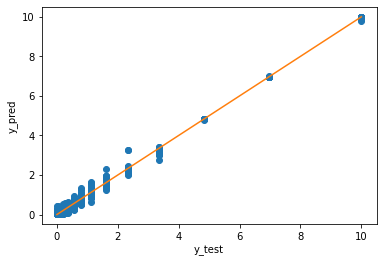

In [13]:
y_pred_part = forest_reg.predict(X_test_part)
plt.plot(ys_test_part['mua1'],y_pred_part,'o')
plt.plot([0,10],[0,10],label='y=y')
print('root_mse: ', np.sqrt(mean_squared_error(ys_test_part['mua1'],y_pred_part)))
plt.xlabel('y_test')
plt.ylabel('y_pred')

root_mse:  0.2945844492574433


Text(0, 0.5, 'y_pred')

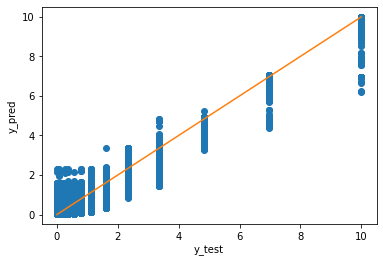

In [14]:
y_pred = forest_reg.predict(X_test)
plt.plot(ys_test['mua1'],y_pred,'o')
plt.plot([0,10],[0,10],label='y=y')
print('root_mse: ', np.sqrt(mean_squared_error(ys_test['mua1'],y_pred)))
plt.xlabel('y_test')
plt.ylabel('y_pred')